# Assignment 4 - Exercise and Concept questions (ISLP, pp. 326-327)

In [18]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

# <font color='blue'>Conceptual Question (Chapter 7, number 3. ISLP, p. 326) </font>
## __Q3__. Suppose we fit a curve with basis functions b1(X) = X, b2(X) = (X − 1)2I(X ≥ 1). (Note that I(X ≥ 1) equals 1 for X ≥ 1 and 0 otherwise.) We fit the linear regression model Y = β0 + β1b1(X) + β2b2(X) + ε, and obtain coefficient estimates βˆ0 = 1, βˆ1 = 1, βˆ2 = −2. Sketch the estimated curve between X = −2 and X = 2. Note the intercepts, slopes, and other relevant information. (James et al., 2023)  


This problem illustrates a piecewise function using basis functions to capture non-linear behavior in a regression setting. The model includes: 
 - b1(X)=X: a linear component across the entire domain,
 - b2(X)=(X−1)2⋅I(X≥1): a hinge function that adds a quadratic "bump" starting at X=1, but is 0 for X<1. 

The full regression model is: Y^ = β0 + β1X + β2(X−1)2I(X≥1)  
Given coefficient estimates:
 - β0 = 1
 - β1 = 1
 - β2 = −2

We can describe this function as:
 - For X<1: Y^=1+X → a straight line with slope 1 and intercept 1.
 - For X≥1: Y^=1+X−2(X−1)2 → a quadratic curve that "bends downward" due to the negative coefficient on the quadratic term. 

This results in a continuous function with a kink (change in curvature) at X=1. The function is still continuous at X=1, but not smooth (the derivative is not continuous). This is typical in models using basis functions with discontinuous derivatives.


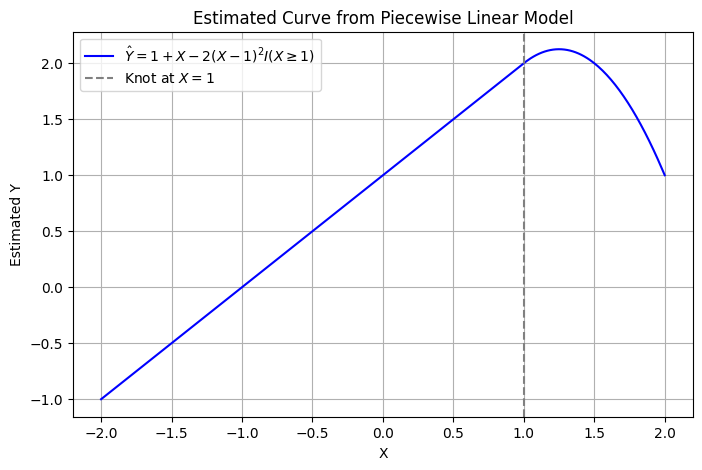

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the basis functions
def b1(x):
    return x

def b2(x):
    return (x - 1)**2 * (x >= 1)

# Define the fitted function using the given coefficients
def y_hat(x):
    return 1 + b1(x) - 2 * b2(x)

# Generate values of X from -2 to 2
x_vals = np.linspace(-2, 2, 400)
y_vals = y_hat(x_vals)

# Plot the estimated curve
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label=r'$\hat{Y} = 1 + X - 2(X-1)^2 I(X \geq 1)$', color='blue')
plt.axvline(x=1, color='gray', linestyle='--', label='Knot at $X=1$')
plt.title("Estimated Curve from Piecewise Linear Model")
plt.xlabel("X")
plt.ylabel("Estimated Y")
plt.grid(True)
plt.legend()
plt.show()


# <font color='blue'>Exercise Question  (ISLP, Chapter 7, number 8, p. 327) <font>

## __Q8__. Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer. 

The provided code fits and visualizes several non-linear regression models to the Auto dataset to explore the potential non-linear relationship between horsepower and miles per gallon (mpg). The goal is to determine whether a linear model is sufficient or if more flexible, non-linear models better capture the relationship between these variables.  

The code first preprocesses the data by ensuring all horsepower values are numeric and free of missing values. It then applies three non-linear modeling techniques: a step function, a cubic spline, and a natural spline. The step function discretizes horsepower into four equal-width bins and fits a piecewise constant model, while the cubic spline fits a smooth curve with three degrees of freedom using B-spline basis functions. The natural spline does the same but constrains the curve to be linear beyond the boundary knots, using four degrees of freedom.  

These models are visualized alongside the raw data to assess fit. In the plots, the curved shapes of the spline-based fits (especially compared to the step function and raw data scatter) clearly capture non-linear trends in the data, suggesting strong evidence of non-linearity in the relationship between horsepower and mpg. The code comprehensively addresses the questions by both fitting non-linear models and generating informative plots that visually justify the presence of non-linear relationships. 

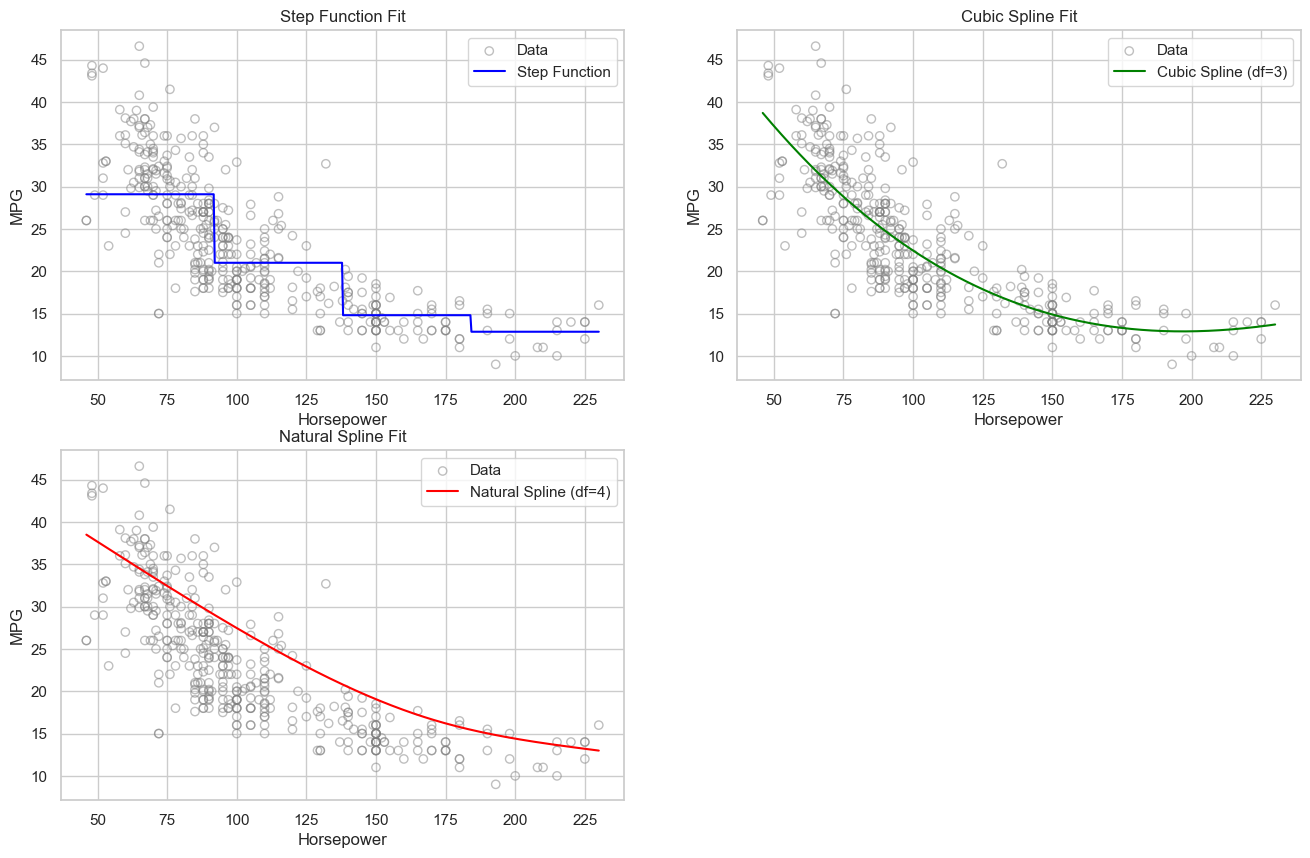

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from patsy import dmatrix
import statsmodels.api as sm

# Load the Auto dataset
# Replace with your own file path if needed
auto = pd.read_csv("Auto.csv", na_values='?').dropna()

# Convert horsepower to numeric if not already
auto['horsepower'] = pd.to_numeric(auto['horsepower'], errors='coerce')

# Drop missing values again after conversion
auto = auto.dropna()

# Extract the relevant variables
X = auto['horsepower']
y = auto['mpg']

# ======================
# STEP FUNCTION APPROACH
# ======================

# Bin horsepower into 4 equal-width bins (you could use quantile bins too)
est = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='uniform')
X_binned = est.fit_transform(X.values.reshape(-1, 1))

# Fit a linear model on the step function
X_step = sm.add_constant(X_binned)
step_model = sm.OLS(y, X_step).fit()

# Predict for plotting
x_grid = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
x_grid_binned = est.transform(x_grid)
x_grid_step = sm.add_constant(x_grid_binned)
y_pred_step = step_model.predict(x_grid_step)

# ======================
# SPLINES APPROACH
# ======================

# Fit a cubic spline with 3 degrees of freedom
spline_basis = dmatrix("bs(x, df=3, degree=3, include_intercept=False)", {"x": X}, return_type='dataframe')
spline_model = sm.OLS(y, sm.add_constant(spline_basis)).fit()

# Predict on a smooth grid
x_spline_basis = dmatrix("bs(x, df=3, degree=3, include_intercept=False)", {"x": x_grid.ravel()}, return_type='dataframe')
y_pred_spline = spline_model.predict(sm.add_constant(x_spline_basis))

# ======================
# NATURAL SPLINES
# ======================

# Natural spline with 4 degrees of freedom
natural_spline_basis = dmatrix("cr(x, df=4)", {"x": X}, return_type='dataframe')
natural_spline_model = sm.OLS(y, sm.add_constant(natural_spline_basis)).fit()

x_nat_basis = dmatrix("cr(x, df=4)", {"x": x_grid.ravel()}, return_type='dataframe')
y_pred_natural = natural_spline_model.predict(sm.add_constant(x_nat_basis))

# ======================
# PLOTS
# ======================

sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

# Raw data scatter
plt.subplot(2, 2, 1)
plt.scatter(X, y, facecolors='none', edgecolors='gray', alpha=0.5, label='Data')
plt.plot(x_grid, y_pred_step, color='blue', label='Step Function')
plt.title("Step Function Fit")
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.legend()

# Cubic spline plot
plt.subplot(2, 2, 2)
plt.scatter(X, y, facecolors='none', edgecolors='gray', alpha=0.5, label='Data')
plt.plot(x_grid, y_pred_spline, color='green', label='Cubic Spline (df=3)')
plt.title("Cubic Spline Fit")
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.legend()

# Natural spline plot
plt.subplot(2, 2, 3)
plt.scatter(X, y, facecolors='none', edgecolors='gray', alpha=0.5, label='Data')
plt.plot(x_grid, y_pred_natural, color='red', label='Natural Spline (df=4)')
plt.title("Natural Spline Fit")
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.legend()
